In [20]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, ConvLSTM2D, Flatten
from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_score, recall_score, f1_score
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load dataset
dataset = pd.read_csv('https://drive.google.com/uc?id=18Hz8VSLDWvM0GwNuXyBUKoGNPhYKVzFF') 
dataset['timestamp'] = pd.to_datetime(dataset['timestamp'])
dataset.set_index('timestamp', inplace=True)

In [3]:
# Select columns and scale
data = dataset[['value']].values
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

In [4]:
sequence_length = 10

# Create sequences
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
    return np.array(sequences)

sequences = create_sequences(data_scaled, sequence_length)

Epoch 1/10
162/162 [==============================] - 2s 5ms/step - loss: 0.0348
Epoch 2/10
162/162 [==============================] - 1s 5ms/step - loss: 0.0054
Epoch 3/10
162/162 [==============================] - 1s 6ms/step - loss: 0.0018
Epoch 4/10
162/162 [==============================] - 1s 5ms/step - loss: 7.3078e-04
Epoch 5/10
162/162 [==============================] - 1s 6ms/step - loss: 3.0885e-04
Epoch 6/10
162/162 [==============================] - 1s 6ms/step - loss: 1.3944e-04
Epoch 7/10
162/162 [==============================] - 1s 5ms/step - loss: 6.4389e-05
Epoch 8/10
162/162 [==============================] - 1s 5ms/step - loss: 2.7443e-05
Epoch 9/10
162/162 [==============================] - 1s 4ms/step - loss: 1.3287e-05
Epoch 10/10
162/162 [==============================] - 1s 4ms/step - loss: 8.7601e-06
Number of Anomalies Detected: 516


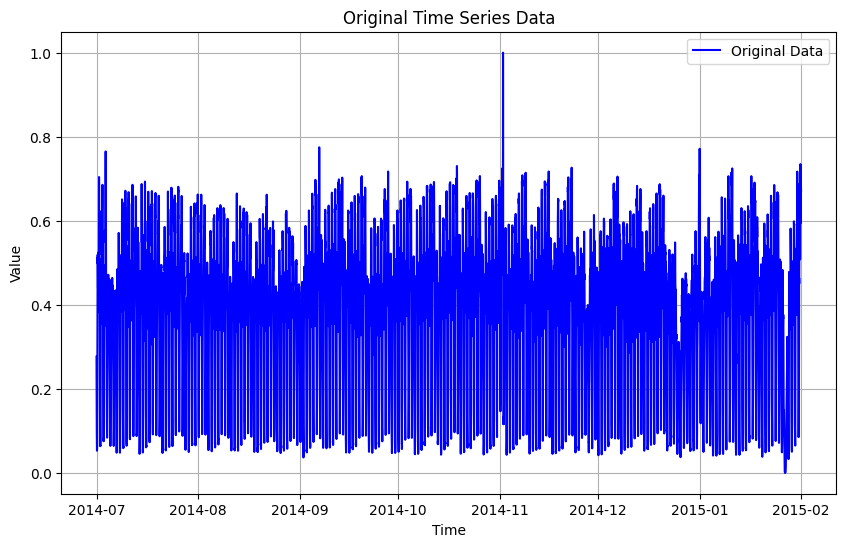

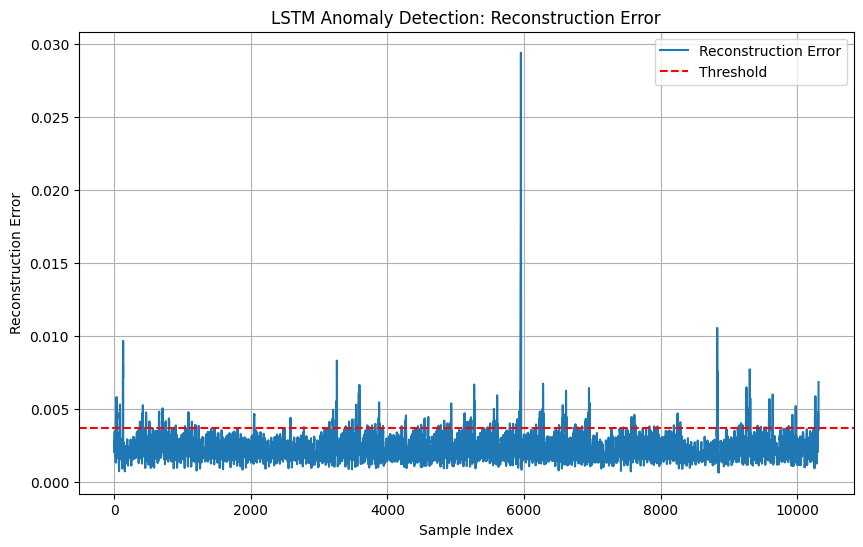

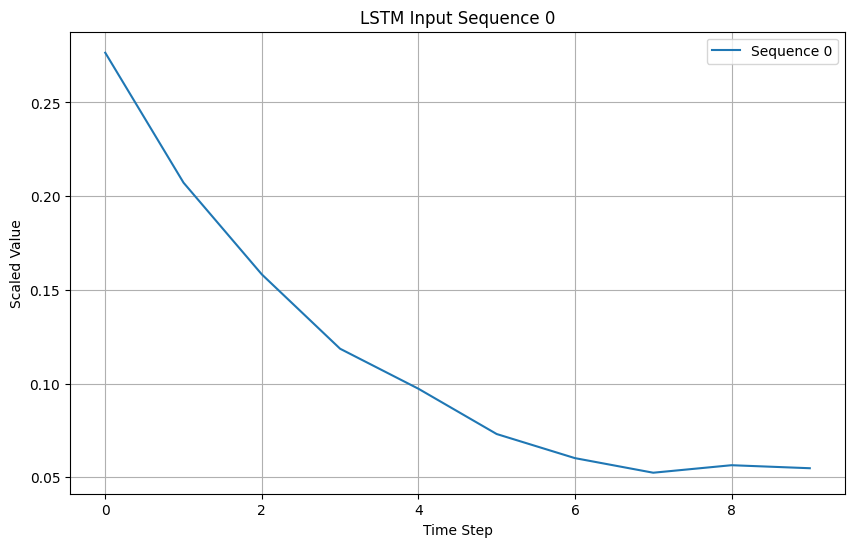

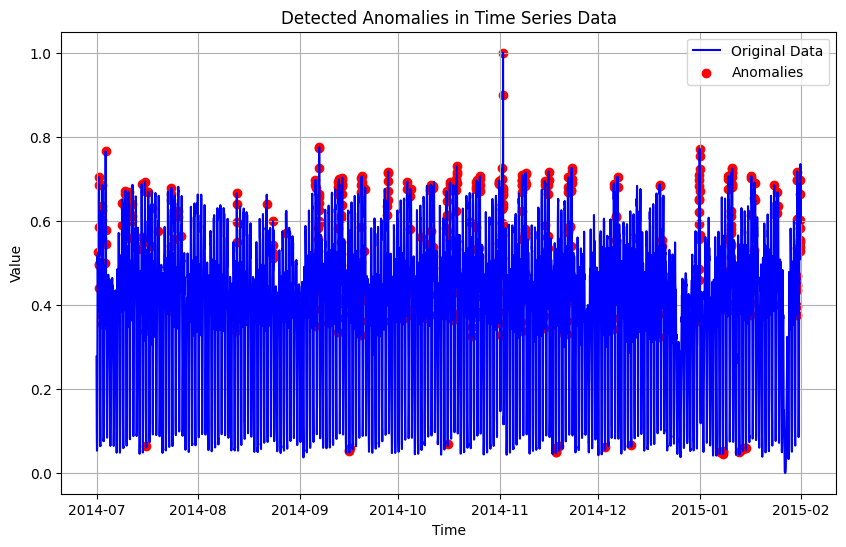

In [12]:
# Model Setup (Unsupervised Learning for Anomaly Detection)
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(sequences.shape[1], sequences.shape[2]), return_sequences=True))  # Ensure return_sequences=True
lstm_model.add(Dense(sequences.shape[2]))
lstm_model.compile(optimizer='adam', loss='mse')

# Train the model on the entire dataset
lstm_model.fit(sequences, sequences, epochs=10, batch_size=64, verbose=1)

# Get the reconstructed sequences
lstm_reconstruction = lstm_model.predict(sequences, verbose=0)

# Ensure that lstm_reconstruction has the same shape as sequences
lstm_reconstruction = lstm_reconstruction.reshape(sequences.shape)

# Compute the reconstruction errors
lstm_errors = np.mean(np.abs(lstm_reconstruction - sequences), axis=(1, 2))

# Compute the threshold (95th percentile of reconstruction errors)
lstm_threshold = np.percentile(lstm_errors, 95)

# Detect anomalies: Any sample with error greater than the threshold is considered an anomaly
lstm_anomalies = lstm_errors > lstm_threshold

# Print how many anomalies were detected
print(f"Number of Anomalies Detected: {np.sum(lstm_anomalies)}")

# Assuming you have a time series 'dataset' with a 'timestamp' column and 'value' column
plt.figure(figsize=(10, 6))
plt.plot(dataset.index, dataset['value'], label='Original Data', color='b')
plt.title("Original Time Series Data")
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Plot the reconstruction error for visualization
plt.figure(figsize=(10, 6))
plt.plot(lstm_errors, label='Reconstruction Error')
plt.axhline(y=lstm_threshold, color='r', linestyle='--', label='Threshold')
plt.title("LSTM Anomaly Detection: Reconstruction Error")
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.grid()
plt.show()

# Visualizing a specific sequence from the input data
sequence_index = 0  # Change to visualize different sequences
sequence = sequences[sequence_index]

plt.figure(figsize=(10, 6))
plt.plot(sequence, label=f"Sequence {sequence_index}")
plt.title(f"LSTM Input Sequence {sequence_index}")
plt.xlabel('Time Step')
plt.ylabel('Scaled Value')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(dataset.index, dataset['value'], label='Original Data', color='b')

# Highlight anomalies in red
anomalies = lstm_anomalies  # List of 0s and 1s where 1 is an anomaly
anomaly_indices = np.where(anomalies == 1)[0]  # Get indices of anomalies
plt.scatter(dataset.index[anomaly_indices], dataset['value'][anomaly_indices], color='r', label='Anomalies')

plt.title("Detected Anomalies in Time Series Data")
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()



Epoch 1/10
162/162 [==============================] - 5s 14ms/step - loss: 0.0243
Epoch 2/10
162/162 [==============================] - 2s 13ms/step - loss: 0.0018
Epoch 3/10
162/162 [==============================] - 2s 10ms/step - loss: 0.0012
Epoch 4/10
162/162 [==============================] - 2s 10ms/step - loss: 0.0011
Epoch 5/10
162/162 [==============================] - 2s 10ms/step - loss: 9.5822e-04
Epoch 6/10
162/162 [==============================] - 2s 10ms/step - loss: 8.6358e-04
Epoch 7/10
162/162 [==============================] - 2s 10ms/step - loss: 6.4399e-04
Epoch 8/10
162/162 [==============================] - 2s 10ms/step - loss: 6.1526e-04
Epoch 9/10
162/162 [==============================] - 2s 10ms/step - loss: 5.2339e-04
Epoch 10/10
162/162 [==============================] - 2s 10ms/step - loss: 5.1152e-04


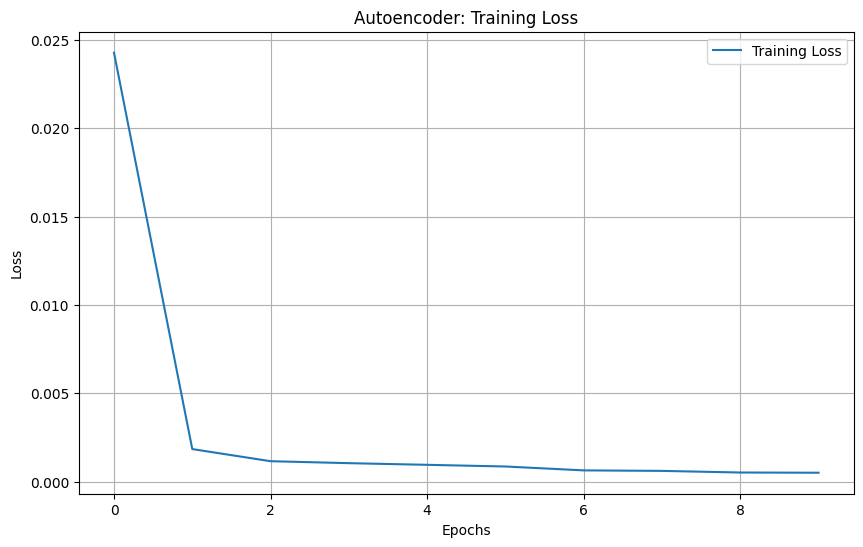

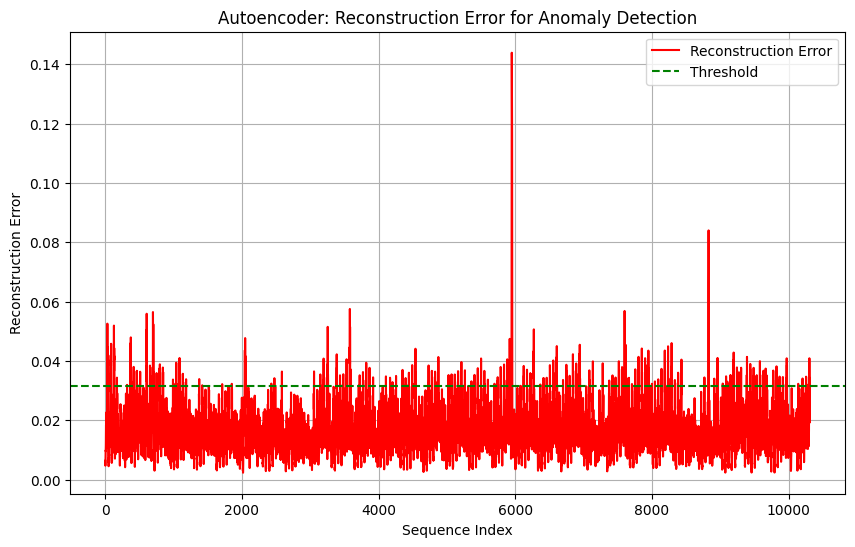

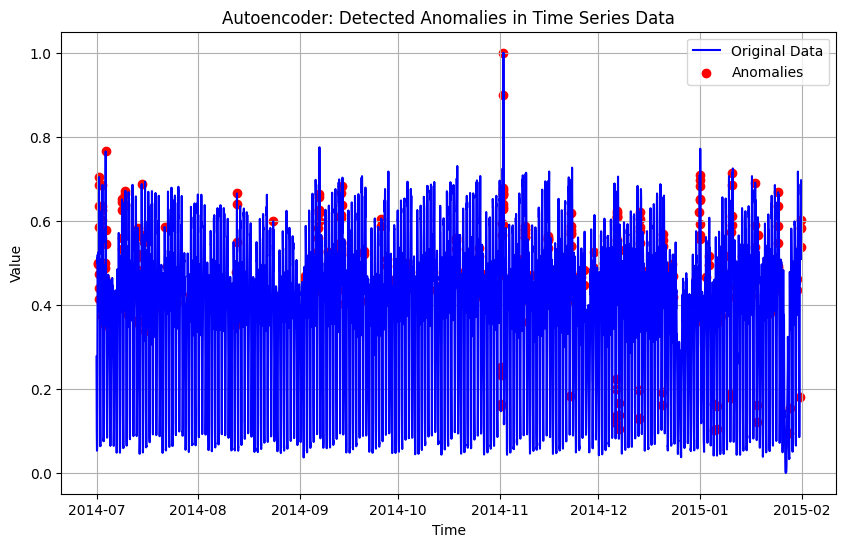

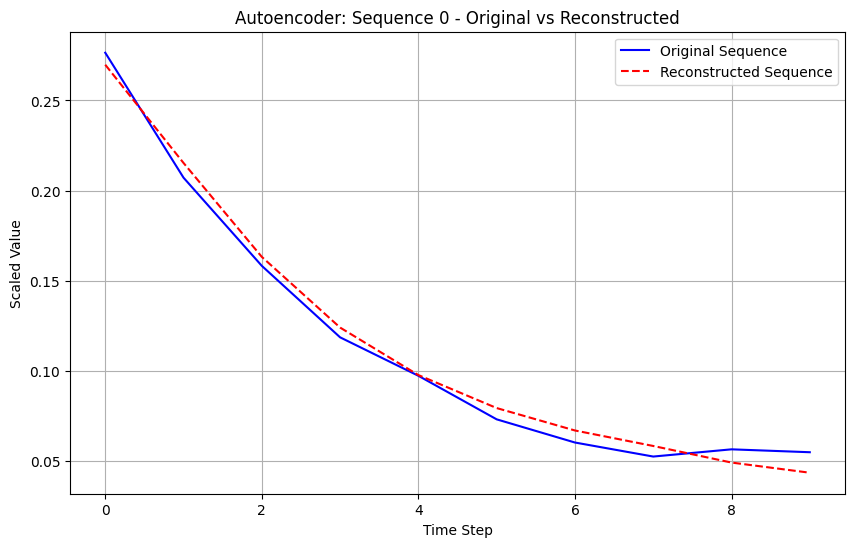

In [13]:
# Model 2: Autoencoder Performance Test
autoencoder_model = Sequential()
autoencoder_model.add(LSTM(64, activation='relu', input_shape=(sequences.shape[1], sequences.shape[2]), return_sequences=False))
autoencoder_model.add(RepeatVector(sequences.shape[1]))
autoencoder_model.add(LSTM(64, activation='relu', return_sequences=True))
autoencoder_model.add(TimeDistributed(Dense(sequences.shape[2])))
autoencoder_model.compile(optimizer='adam', loss='mse')

autoencoder_history = autoencoder_model.fit(sequences, sequences, epochs=10, batch_size=64, verbose=1)

autoencoder_reconstruction = autoencoder_model.predict(sequences, verbose=0)
autoencoder_reconstruction_error = np.mean(np.abs(autoencoder_reconstruction - sequences), axis=(1, 2))
autoencoder_threshold = np.percentile(autoencoder_reconstruction_error, 95)

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(autoencoder_history.history['loss'], label='Training Loss')
plt.title('Autoencoder: Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot reconstruction error for each sequence
plt.figure(figsize=(10, 6))
plt.plot(autoencoder_reconstruction_error, label='Reconstruction Error', color='r')
plt.axhline(y=autoencoder_threshold, color='g', linestyle='--', label='Threshold')
plt.title("Autoencoder: Reconstruction Error for Anomaly Detection")
plt.xlabel('Sequence Index')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.grid(True)
plt.show()

# Determine which sequences are anomalies based on the threshold
anomalies_autoencoder = (autoencoder_reconstruction_error > autoencoder_threshold).astype(int)

# Plot the original time series with anomalies highlighted
plt.figure(figsize=(10, 6))
plt.plot(dataset.index[:len(autoencoder_reconstruction_error)], dataset['value'][:len(autoencoder_reconstruction_error)], label='Original Data', color='b')

# Highlight anomalies in red
anomaly_indices = np.where(anomalies_autoencoder == 1)[0]  # Get indices of anomalies
plt.scatter(dataset.index[anomaly_indices], dataset['value'][anomaly_indices], color='r', label='Anomalies')

plt.title("Autoencoder: Detected Anomalies in Time Series Data")
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Choose a specific sequence to visualize
sequence_index = 0  # Change this to visualize different sequences
original_sequence = sequences[sequence_index]
reconstructed_sequence = autoencoder_reconstruction[sequence_index]

plt.figure(figsize=(10, 6))
plt.plot(original_sequence, label='Original Sequence', color='b')
plt.plot(reconstructed_sequence, label='Reconstructed Sequence', color='r', linestyle='--')
plt.title(f"Autoencoder: Sequence {sequence_index} - Original vs Reconstructed")
plt.xlabel('Time Step')
plt.ylabel('Scaled Value')
plt.legend()
plt.grid(True)
plt.show()


Epoch 1/10
162/162 [==============================] - 14s 53ms/step - loss: 0.0310
Epoch 2/10
162/162 [==============================] - 8s 51ms/step - loss: 0.0025
Epoch 3/10
162/162 [==============================] - 10s 60ms/step - loss: 3.4691e-04
Epoch 4/10
162/162 [==============================] - 8s 51ms/step - loss: 1.0401e-04
Epoch 5/10
162/162 [==============================] - 8s 52ms/step - loss: 4.5565e-05
Epoch 6/10
162/162 [==============================] - 8s 52ms/step - loss: 2.7190e-05
Epoch 7/10
162/162 [==============================] - 9s 56ms/step - loss: 2.0359e-05
Epoch 8/10
162/162 [==============================] - 11s 66ms/step - loss: 1.6784e-05
Epoch 9/10
162/162 [==============================] - 10s 63ms/step - loss: 1.4317e-05
Epoch 10/10
162/162 [==============================] - 9s 53ms/step - loss: 1.2324e-05
ConvLSTM Reconstruction Shape: (10310, 10, 1)


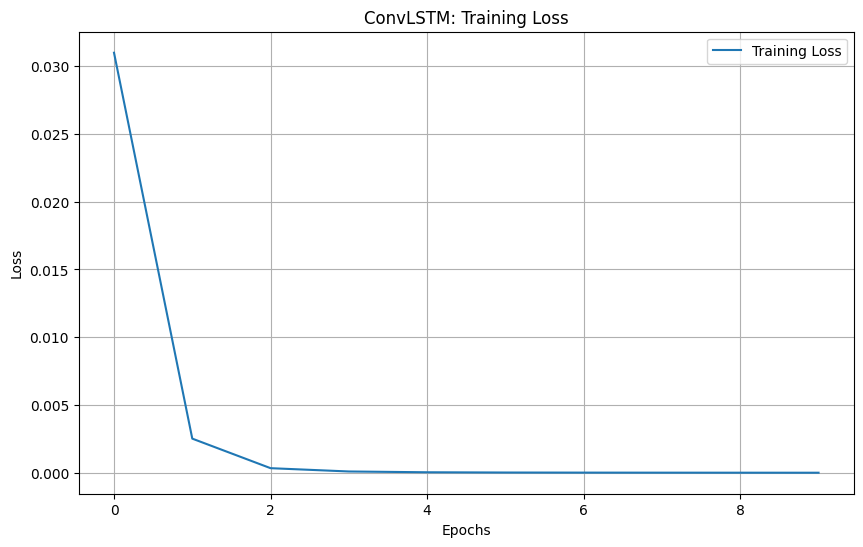

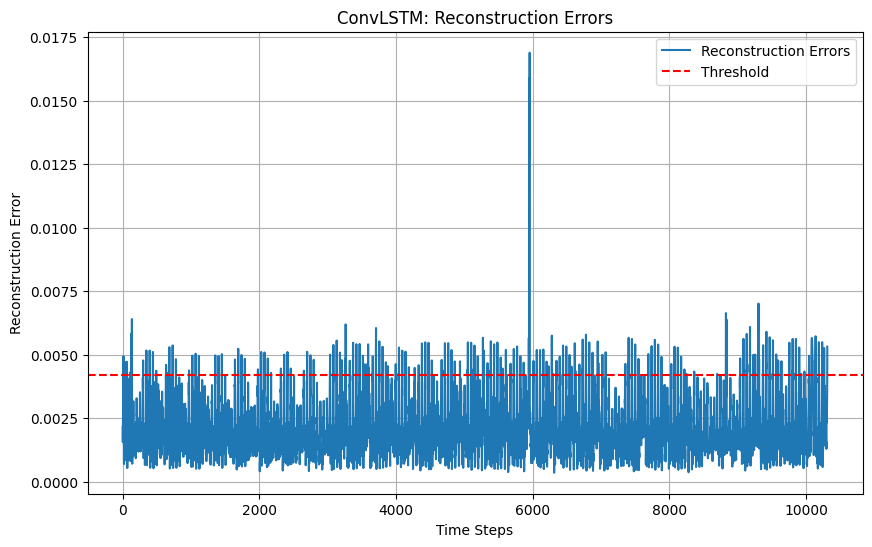

ConvLSTM Mean Reconstruction Error: 0.002081
ConvLSTM Threshold (95th Percentile): 0.004214


In [19]:
# Reshaping to 5D input format: (batch_size, time_steps, rows, columns, channels)
# For ConvLSTM, treat each sequence as a 1x1 grid with 1 feature (channel)
X_train_reshaped = sequences.reshape((sequences.shape[0], sequences.shape[1], 1, 1, sequences.shape[2])) 

# Build the ConvLSTM model
convlstm_model = Sequential()
convlstm_model.add(ConvLSTM2D(64, (3, 3), padding='same', input_shape=(sequences.shape[1], 1, 1, sequences.shape[2]), return_sequences=True))
convlstm_model.add(ConvLSTM2D(64, (3, 3), padding='same', return_sequences=True))
convlstm_model.add(TimeDistributed(Flatten()))  # Flatten each time step independently
convlstm_model.add(TimeDistributed(Dense(sequences.shape[2])))  # Output same shape as input sequences
convlstm_model.compile(optimizer='adam', loss='mse')

# Train the model
convlstm_history = convlstm_model.fit(X_train_reshaped, sequences, epochs=10, batch_size=64, verbose=1)

# Get the reconstructed sequences
convlstm_reconstruction = convlstm_model.predict(X_train_reshaped, verbose=0)

# Ensure that the reconstruction has the same shape as sequences
print(f"ConvLSTM Reconstruction Shape: {convlstm_reconstruction.shape}")
convlstm_reconstruction = convlstm_reconstruction.reshape(sequences.shape)

# Compute reconstruction errors
convlstm_errors = np.mean(np.abs(sequences - convlstm_reconstruction), axis=(1, 2))

# Compute threshold (95th percentile of reconstruction errors)
convlstm_threshold = np.percentile(convlstm_errors, 95)

# 1. Visualize Training Loss
plt.figure(figsize=(10, 6))
plt.plot(convlstm_history.history['loss'], label='Training Loss')
plt.title('ConvLSTM: Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# 2. Visualize Reconstruction Errors
plt.figure(figsize=(10, 6))
plt.plot(convlstm_errors, label='Reconstruction Errors')
plt.axhline(y=convlstm_threshold, color='r', linestyle='--', label='Threshold')
plt.title('ConvLSTM: Reconstruction Errors')
plt.xlabel('Time Steps')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.grid()
plt.show()

# 3. Visualize Anomalies
# Anomalies are detected if the reconstruction error exceeds the threshold
# anomalies = convlstm_errors > convlstm_threshold
# plt.figure(figsize=(10, 6))
# plt.plot(convlstm_errors, label='Reconstruction Errors')
# plt.plot(anomalies * max(convlstm_errors), 'ro', label='Anomalies')  # Highlight anomalies
# plt.axhline(y=convlstm_threshold, color='r', linestyle='--', label='Threshold')
# plt.title('ConvLSTM: Anomaly Detection')
# plt.xlabel('Time Steps')
# plt.ylabel('Reconstruction Error')
# plt.legend()
# plt.grid()
# plt.show()

print(f"ConvLSTM Mean Reconstruction Error: {np.mean(convlstm_errors):.6f}")
print(f"ConvLSTM Threshold (95th Percentile): {convlstm_threshold:.6f}")

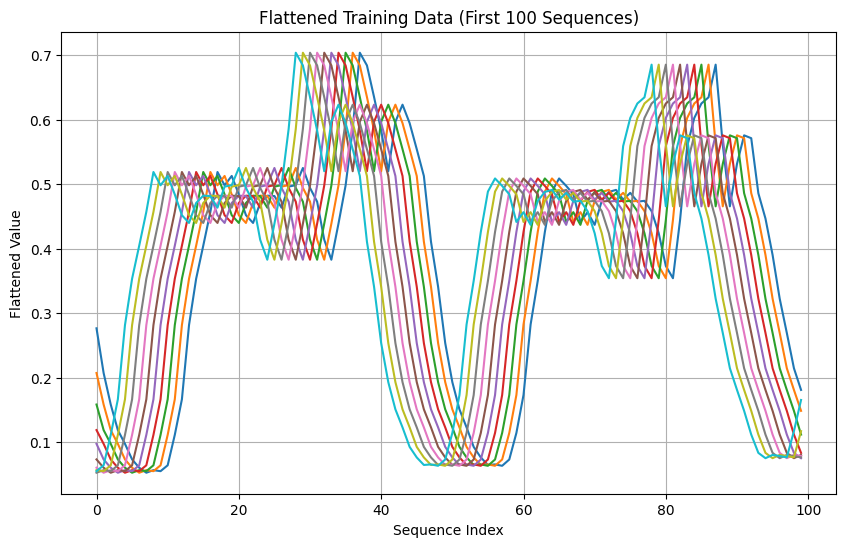

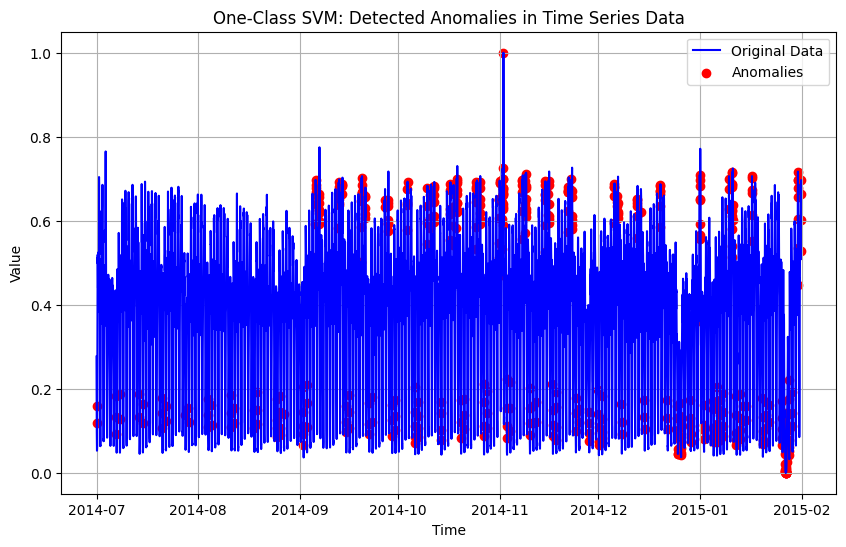

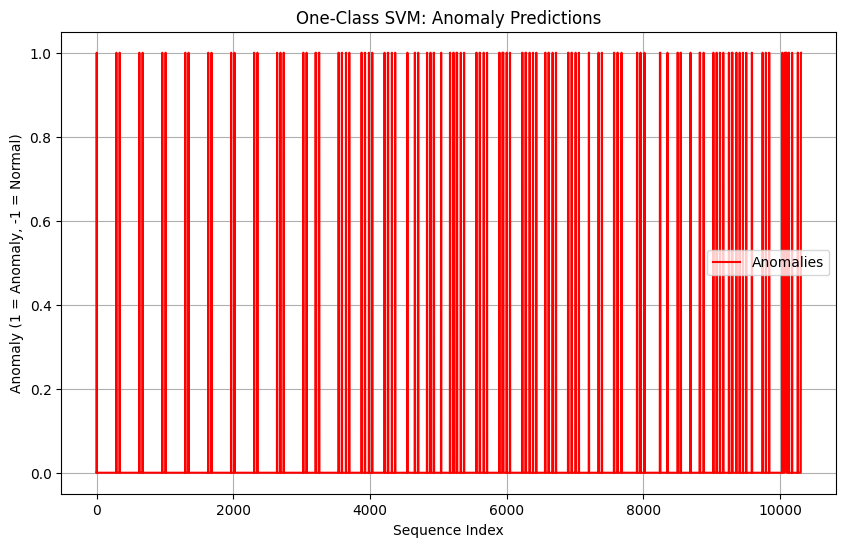

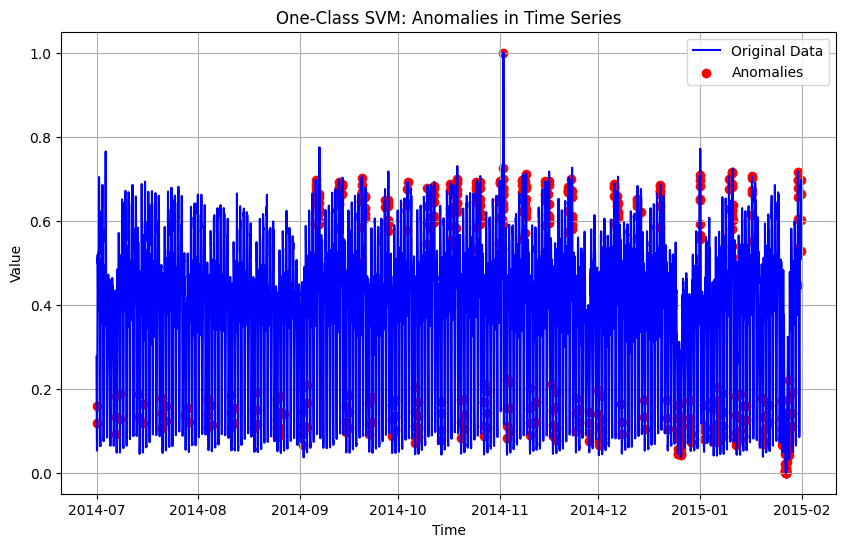

One-Class SVM Detected Anomalies: 514


In [18]:
# Model 4: One-Class SVM Performance Test
X_train_flat = sequences.reshape((sequences.shape[0], -1))
svm = OneClassSVM(nu=0.05, kernel='rbf', gamma=0.1)
svm.fit(X_train_flat)

svm_predictions = svm.predict(X_train_flat)
svm_anomalies = (svm_predictions == -1).astype(int)

# Visualize the first few sequences (after flattening) for a basic understanding
plt.figure(figsize=(10, 6))
plt.plot(X_train_flat[:100])  # Plotting the first 100 flattened sequences
plt.title('Flattened Training Data (First 100 Sequences)')
plt.xlabel('Sequence Index')
plt.ylabel('Flattened Value')
plt.grid(True)
plt.show()

# Plot the original time series data and highlight the detected anomalies
plt.figure(figsize=(10, 6))
plt.plot(dataset.index[:len(svm_anomalies)], dataset['value'][:len(svm_anomalies)], label='Original Data', color='b')

# Highlight anomalies in red
anomaly_indices = np.where(svm_anomalies == 1)[0]  # Get indices of anomalies
plt.scatter(dataset.index[anomaly_indices], dataset['value'][anomaly_indices], color='r', label='Anomalies')

plt.title("One-Class SVM: Detected Anomalies in Time Series Data")
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Visualizing the SVM anomaly predictions
plt.figure(figsize=(10, 6))
plt.plot(svm_anomalies, label='Anomalies', color='r')
plt.title("One-Class SVM: Anomaly Predictions")
plt.xlabel('Sequence Index')
plt.ylabel('Anomaly (1 = Anomaly, -1 = Normal)')
plt.legend()
plt.grid(True)
plt.show()

# Visualize original time series and highlight anomalies detected by One-Class SVM
plt.figure(figsize=(10, 6))
plt.plot(dataset.index[:len(svm_anomalies)], dataset['value'][:len(svm_anomalies)], label='Original Data', color='b')

# Mark anomalies in red
anomaly_indices = np.where(svm_anomalies == 1)[0]  # Get indices of anomalies
plt.scatter(dataset.index[anomaly_indices], dataset['value'][anomaly_indices], color='r', label='Anomalies')

plt.title("One-Class SVM: Anomalies in Time Series")
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

print(f"One-Class SVM Detected Anomalies: {np.sum(svm_anomalies)}")

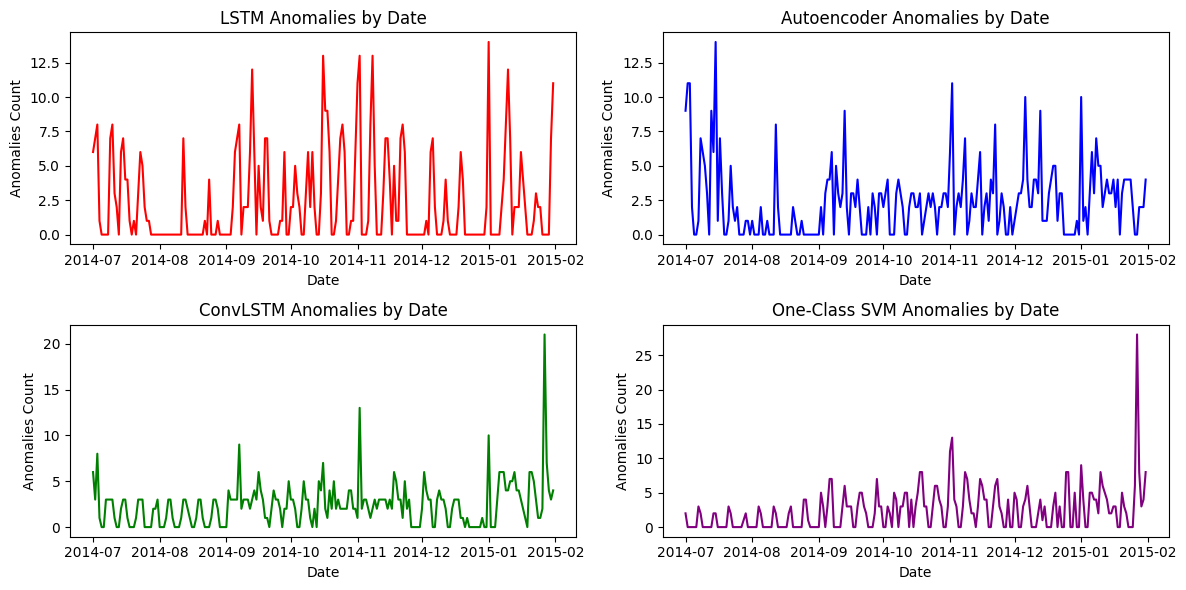

LSTM Anomalies by Date:
2014-07-01     6
2014-07-02     7
2014-07-03     8
2014-07-04     1
2014-07-05     0
              ..
2015-01-27     0
2015-01-28     0
2015-01-29     0
2015-01-30     7
2015-01-31    11
Name: lstm_anomalies, Length: 215, dtype: int32
Autoencoder Anomalies by Date:
2014-07-01     9
2014-07-02    11
2014-07-03    11
2014-07-04     2
2014-07-05     0
              ..
2015-01-27     0
2015-01-28     2
2015-01-29     2
2015-01-30     2
2015-01-31     4
Name: autoencoder_anomalies, Length: 215, dtype: int32
ConvLSTM Anomalies by Date:
2014-07-01     6
2014-07-02     3
2014-07-03     8
2014-07-04     1
2014-07-05     0
              ..
2015-01-27    21
2015-01-28     7
2015-01-29     4
2015-01-30     3
2015-01-31     4
Name: convlstm_anomalies, Length: 215, dtype: int32
One-Class SVM Anomalies by Date:
2014-07-01     2
2014-07-02     0
2014-07-03     0
2014-07-04     0
2014-07-05     0
              ..
2015-01-27    28
2015-01-28     8
2015-01-29     3
2015-01-30     

In [28]:
# Assuming dataset is already loaded and preprocessed, with 'timestamp' as index

# Example anomaly detection arrays (replace with actual model anomaly outputs)
lstm_anomalies = (lstm_errors > lstm_threshold).astype(int)
autoencoder_anomalies = (autoencoder_reconstruction_error > autoencoder_threshold).astype(int)
convlstm_anomalies = (convlstm_errors > convlstm_threshold).astype(int)
svm_anomalies = (svm_anomalies == 1).astype(int)

# The length of the sequences is shorter than the original dataset due to sequence length
# Number of rows that will be padded with 0s (anomalies = 0) at the beginning of the dataset
padding_size = len(dataset) - len(lstm_anomalies)

# Pad the anomaly arrays with 0s at the start
lstm_anomalies_padded = np.pad(lstm_anomalies, (padding_size, 0), mode='constant', constant_values=0)
autoencoder_anomalies_padded = np.pad(autoencoder_anomalies, (padding_size, 0), mode='constant', constant_values=0)
convlstm_anomalies_padded = np.pad(convlstm_anomalies, (padding_size, 0), mode='constant', constant_values=0)
svm_anomalies_padded = np.pad(svm_anomalies, (padding_size, 0), mode='constant', constant_values=0)

# Add these padded anomaly arrays to the dataset
dataset['lstm_anomalies'] = lstm_anomalies_padded
dataset['autoencoder_anomalies'] = autoencoder_anomalies_padded
dataset['convlstm_anomalies'] = convlstm_anomalies_padded
dataset['svm_anomalies'] = svm_anomalies_padded

# Now you can group anomalies by date
lstm_anomalies_by_date = dataset.groupby(dataset.index.date)['lstm_anomalies'].sum()
autoencoder_anomalies_by_date = dataset.groupby(dataset.index.date)['autoencoder_anomalies'].sum()
convlstm_anomalies_by_date = dataset.groupby(dataset.index.date)['convlstm_anomalies'].sum()
svm_anomalies_by_date = dataset.groupby(dataset.index.date)['svm_anomalies'].sum()

# Plot the anomalies by date
plt.figure(figsize=(12, 6))

# LSTM Anomalies
plt.subplot(2, 2, 1)
plt.plot(lstm_anomalies_by_date, label='LSTM Anomalies', color='red')
plt.title('LSTM Anomalies by Date')
plt.xlabel('Date')
plt.ylabel('Anomalies Count')

# Autoencoder Anomalies
plt.subplot(2, 2, 2)
plt.plot(autoencoder_anomalies_by_date, label='Autoencoder Anomalies', color='blue')
plt.title('Autoencoder Anomalies by Date')
plt.xlabel('Date')
plt.ylabel('Anomalies Count')

# ConvLSTM Anomalies
plt.subplot(2, 2, 3)
plt.plot(convlstm_anomalies_by_date, label='ConvLSTM Anomalies', color='green')
plt.title('ConvLSTM Anomalies by Date')
plt.xlabel('Date')
plt.ylabel('Anomalies Count')

# One-Class SVM Anomalies
plt.subplot(2, 2, 4)
plt.plot(svm_anomalies_by_date, label='SVM Anomalies', color='purple')
plt.title('One-Class SVM Anomalies by Date')
plt.xlabel('Date')
plt.ylabel('Anomalies Count')

plt.tight_layout()
plt.show()

# Display the counts
print("LSTM Anomalies by Date:")
print(lstm_anomalies_by_date)

print("Autoencoder Anomalies by Date:")
print(autoencoder_anomalies_by_date)

print("ConvLSTM Anomalies by Date:")
print(convlstm_anomalies_by_date)

print("One-Class SVM Anomalies by Date:")
print(svm_anomalies_by_date)


In [32]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

# True anomalies (provided dates)
true_anomalies_dates = [
    '2014-07-04', '2014-09-01', '2014-10-13', '2014-11-04', '2014-11-11', '2014-11-27', '2014-12-25',
    '2015-01-01', '2015-01-19', '2014-11-02', '2014-11-27', '2014-12-24', '2014-12-25', '2015-01-01',
    '2015-01-26', '2015-01-27'
]

# Convert the true anomalies dates to a pandas Datetime index
true_anomalies = pd.to_datetime(true_anomalies_dates)

# Create a boolean array where 1 indicates an anomaly and 0 indicates non-anomaly
true_anomalies_array = np.zeros(len(dataset), dtype=int)

# Mark the true anomalies as 1 in the array
for date in true_anomalies:
    if date in dataset.index:
        true_anomalies_array[dataset.index == date] = 1

# Ensure the length of the predicted arrays matches the true anomalies array length
# Get the length difference between true anomalies and model predictions
length_diff = len(dataset) - len(lstm_anomalies)

# Pad the predicted anomaly arrays (lstm_anomalies, autoencoder_anomalies, etc.) with zeros at the end
lstm_anomalies_padded = np.pad(lstm_anomalies, (0, length_diff), mode='constant', constant_values=0)
autoencoder_anomalies_padded = np.pad(autoencoder_anomalies, (0, length_diff), mode='constant', constant_values=0)
convlstm_anomalies_padded = np.pad(convlstm_anomalies, (0, length_diff), mode='constant', constant_values=0)
svm_anomalies_padded = np.pad(svm_anomalies, (0, length_diff), mode='constant', constant_values=0)

# Calculate Precision, Recall, and F1 Score for each model
def calculate_performance_metrics(predictions, ground_truth):
    precision = precision_score(ground_truth, predictions)
    recall = recall_score(ground_truth, predictions)
    f1 = f1_score(ground_truth, predictions)
    return precision, recall, f1

# For each model, now that all arrays are the same length
lstm_precision, lstm_recall, lstm_f1 = calculate_performance_metrics(lstm_anomalies_padded, true_anomalies_array)
autoencoder_precision, autoencoder_recall, autoencoder_f1 = calculate_performance_metrics(autoencoder_anomalies_padded, true_anomalies_array)
convlstm_precision, convlstm_recall, convlstm_f1 = calculate_performance_metrics(convlstm_anomalies_padded, true_anomalies_array)
svm_precision, svm_recall, svm_f1 = calculate_performance_metrics(svm_anomalies_padded, true_anomalies_array)

# Print the results
print("LSTM Model Performance:")
print(f"Precision: {lstm_precision:.4f}, Recall: {lstm_recall:.4f}, F1-Score: {lstm_f1:.4f}")

print("Autoencoder Model Performance:")
print(f"Precision: {autoencoder_precision:.4f}, Recall: {autoencoder_recall:.4f}, F1-Score: {autoencoder_f1:.4f}")

print("ConvLSTM Model Performance:")
print(f"Precision: {convlstm_precision:.4f}, Recall: {convlstm_recall:.4f}, F1-Score: {convlstm_f1:.4f}")

print("One-Class SVM Model Performance:")
print(f"Precision: {svm_precision:.4f}, Recall: {svm_recall:.4f}, F1-Score: {svm_f1:.4f}")


LSTM Model Performance:
Precision: 0.0039, Recall: 0.1538, F1-Score: 0.0076
Autoencoder Model Performance:
Precision: 0.0039, Recall: 0.1538, F1-Score: 0.0076
ConvLSTM Model Performance:
Precision: 0.0039, Recall: 0.1538, F1-Score: 0.0076
One-Class SVM Model Performance:
Precision: 0.0078, Recall: 0.3077, F1-Score: 0.0152


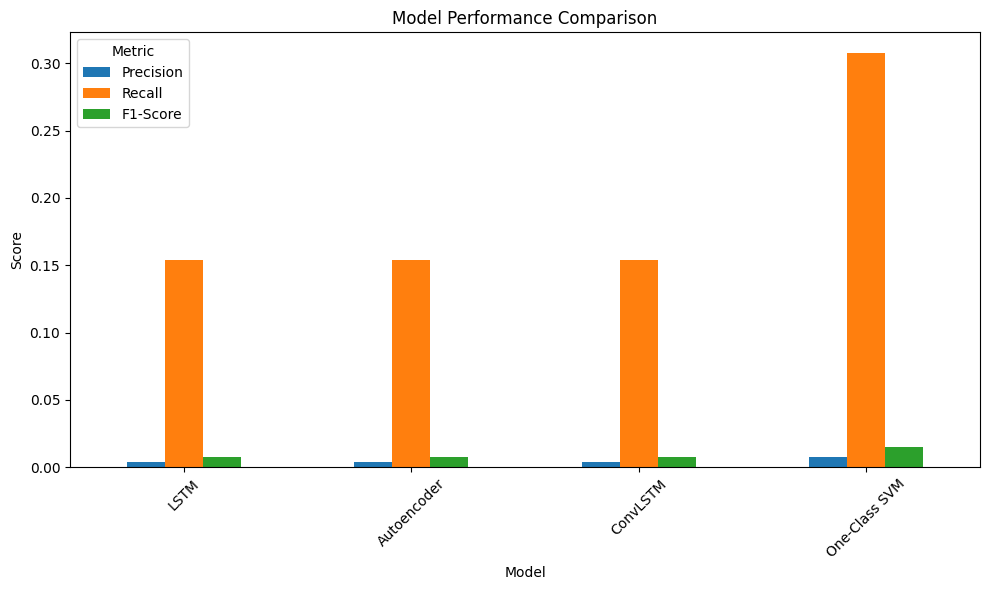

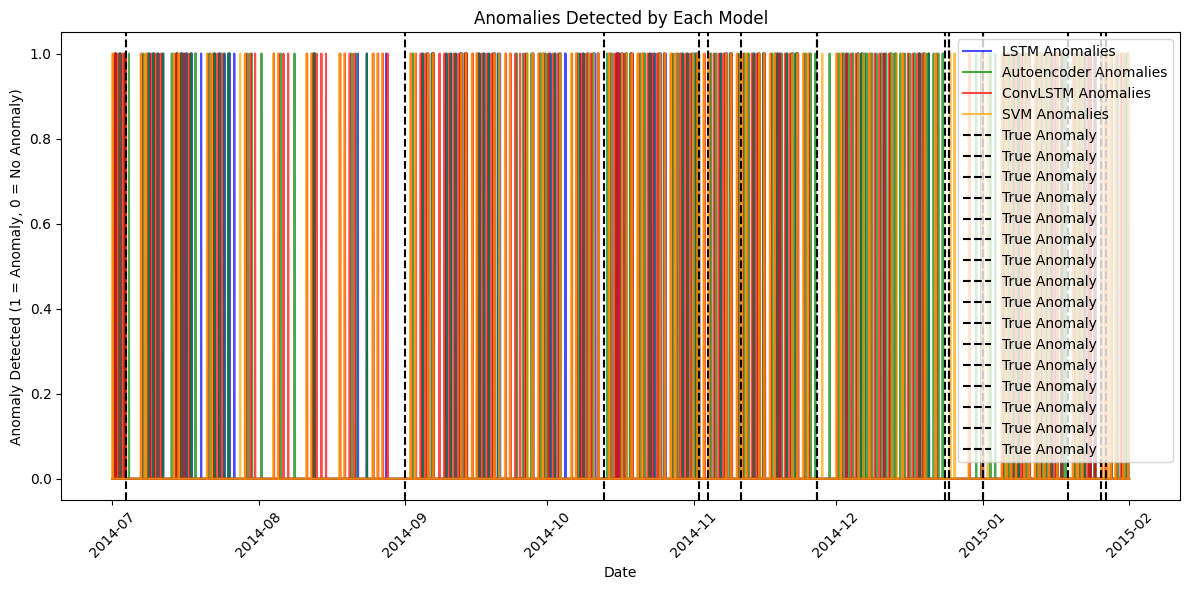

In [35]:
# Prepare data for bar chart visualization of Precision, Recall, and F1-Score
metrics = {
    'Model': ['LSTM', 'Autoencoder', 'ConvLSTM', 'One-Class SVM'],
    'Precision': [lstm_precision, autoencoder_precision, convlstm_precision, svm_precision],
    'Recall': [lstm_recall, autoencoder_recall, convlstm_recall, svm_recall],
    'F1-Score': [lstm_f1, autoencoder_f1, convlstm_f1, svm_f1]
}

metrics_df = pd.DataFrame(metrics)

# Plot Precision, Recall, and F1-Score bar chart
fig, ax = plt.subplots(figsize=(10, 6))
metrics_df.set_index('Model').plot(kind='bar', ax=ax)
ax.set_title('Model Performance Comparison')
ax.set_ylabel('Score')
ax.set_xlabel('Model')
ax.legend(title='Metric')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot anomalies detected by each model and true anomalies
fig, ax = plt.subplots(figsize=(12, 6))

# Plot anomalies detected by each model
dataset['lstm_anomalies'] = lstm_anomalies_padded
dataset['autoencoder_anomalies'] = autoencoder_anomalies_padded
dataset['convlstm_anomalies'] = convlstm_anomalies_padded
dataset['svm_anomalies'] = svm_anomalies_padded

# Plotting the anomalies
ax.plot(dataset.index, dataset['lstm_anomalies'], label='LSTM Anomalies', linestyle='-', color='blue', alpha=0.7)
ax.plot(dataset.index, dataset['autoencoder_anomalies'], label='Autoencoder Anomalies', linestyle='-', color='green', alpha=0.7)
ax.plot(dataset.index, dataset['convlstm_anomalies'], label='ConvLSTM Anomalies', linestyle='-', color='red', alpha=0.7)
ax.plot(dataset.index, dataset['svm_anomalies'], label='SVM Anomalies', linestyle='-', color='orange', alpha=0.7)

# Mark true anomalies with vertical lines
for anomaly_date in true_anomalies:
    if anomaly_date in dataset.index:
        ax.axvline(x=anomaly_date, color='black', linestyle='--', label='True Anomaly')

# Customize the plot
ax.set_title('Anomalies Detected by Each Model')
ax.set_xlabel('Date')
ax.set_ylabel('Anomaly Detected (1 = Anomaly, 0 = No Anomaly)')
ax.legend(loc='upper right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
# # Model 5: Seasonal Decomposition Performance Test
# series = dataset['value']
# decomposition = seasonal_decompose(series, model='additive', period=sequence_length)
# trend = decomposition.trend.dropna()
# seasonal = decomposition.seasonal.dropna()
# residual = decomposition.resid.dropna()

# seasonal_threshold = np.percentile(np.abs(residual), 95)

# print(f"Seasonal Decomposition Residual Mean: {np.mean(residual):.6f}")
# print(f"Seasonal Decomposition Threshold (95th Percentile): {seasonal_threshold:.6f}")

Seasonal Decomposition Residual Mean: -0.000013
Seasonal Decomposition Threshold (95th Percentile): 0.092675
